# Notebook for the Chemostat Model

In [1]:
import numpy as np
import numpy.ma as ma
import scipy.optimize
import matplotlib.pyplot as plt
import math
import time
import pandas as pd
import seaborn as sns
from importlib import reload
import Functions_for_Chemostat as ffc
from matplotlib import ticker, cm
from functools import partial
from scipy.integrate import odeint
from scipy.optimize import fsolve
%matplotlib inline

sns.set()

## Growth functions depending on CTX concentration and parameters

R = Resistant = Triple = TEM-52

S = Susceptible = G238S = TEM-19

In [2]:
p_R = {"Vmax": 3.20e-4, "ka":69, "B": -96.5, "T":0.146, 
       "ec50": 27716, "h": 3.38, "k": 1.8e-4, "yxg": 2e9}
p_S = {"Vmax":6.69e-4, "ka":319, "B": -1.57, "T": 0.183, "ec50": 1.87, 
       "h": 3.42, "k": 1.8e-4, "yxg": 2e9}
p_R_stored = p_R.copy()
p_S_stored = p_S.copy()

In [3]:
p_R_highVmax = {"Vmax": 10*3.20e-4, "ka":69, "B": -96.5, "T":0.146, 
       "ec50": 27716, "h": 3.38, "k": 1.8e-4, "yxg": 2e9}
p_S_highVmax = {"Vmax": 10*6.69e-4, "ka":319, "B": -1.57, "T": 0.183, "ec50": 1.87, 
       "h": 3.42, "k": 1.8e-4, "yxg": 2e9}
p_R_lowVmax = {"Vmax": 0.1*3.20e-4, "ka":69, "B": -96.5, "T":0.146, 
       "ec50": 27716, "h": 3.38, "k": 1.8e-4, "yxg": 2e9}
p_S_lowVmax = {"Vmax": 0.1*6.69e-4, "ka":319, "B": -1.57, "T": 0.183, "ec50": 1.87, 
       "h": 3.42, "k": 1.8e-4, "yxg": 2e9}
p_R_highGrowth = {"Vmax": 3.20e-4, "ka":69, "B": -96.5, "T":0.146+0.03, 
       "ec50": 27716, "h": 3.38, "k": 1.8e-4, "yxg": 2e9}
p_S_highGrowth = {"Vmax": 6.69e-4, "ka":319, "B": -1.57, "T": 0.183+0.03, "ec50": 1.87, 
       "h": 3.42, "k": 1.8e-4, "yxg": 2e9}
p_R_lowGrowth = {"Vmax": 3.20e-4, "ka":69, "B": -96.5, "T":0.146-0.03, 
       "ec50": 27716, "h": 3.38, "k": 1.8e-4, "yxg": 2e9}
p_S_lowGrowth = {"Vmax": 6.69e-4, "ka":319, "B": -1.57, "T": 0.183-0.03, "ec50": 1.87, 
       "h": 3.42, "k": 1.8e-4, "yxg": 2e9}

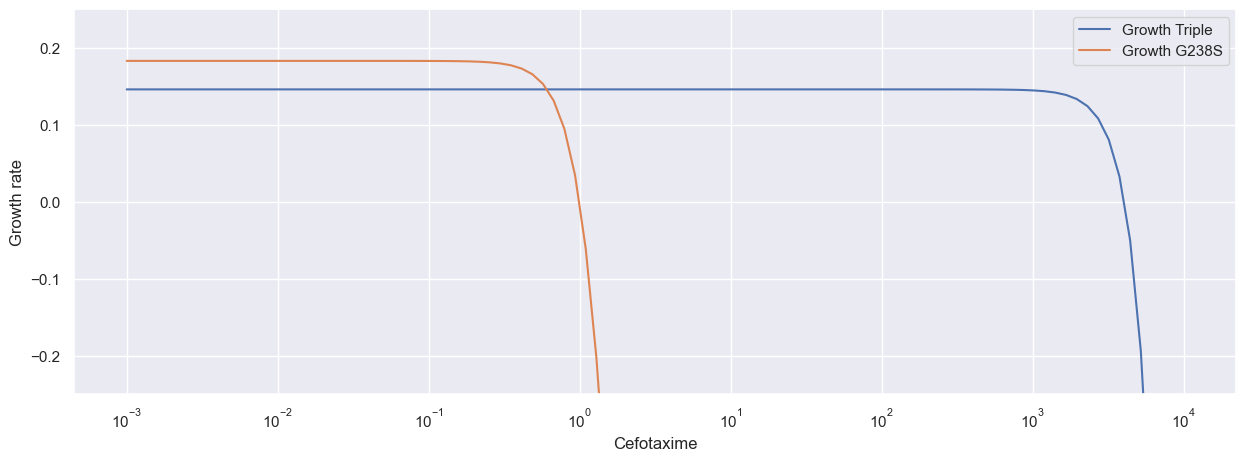

In [4]:
xval = np.logspace(-3, 4, num=100)
yvalx = [ffc.growth(a, **p_R) for a in xval]
yvaly = [ffc.growth(a, **p_S) for a in xval]
fig, axes = plt.subplots(figsize=(15,5))
axes.plot(xval, yvalx)
axes.plot(xval, yvaly)
axes.set_xlabel('Cefotaxime')
axes.set_ylabel('Growth rate')
axes.set_ylim(-0.25, 0.25)
axes.set_xscale('log')
axes.legend(tuple(['Growth Triple','Growth G238S']))


## Calculations of the coexistence area

First we find the antibiotic concentration for which the maximal growth rate (with respect to substrate) of both strains is equal.

This is the CTX concentrations in the chemostat at a steady state in which both strains are present.

In [5]:
func_equal_growth = lambda a: (ffc.growth(a, **p_R) - ffc.growth(a, **p_S))**2
sol_a_eq = fsolve(func_equal_growth, 0.6)[0]

In [6]:
mu_coex = ffc.growth(sol_a_eq, **p_R)

### Printing some of the results and checks for some of the values

In [7]:
print('minimum g to survive for susceptible strain at d=0.1', ffc.g_min(0.1, mu=ffc.growth(0, **p_S), **p_S))
print('minimum g to survive for resistant strain at d=0.1', ffc.g_min(0.1, mu=ffc.growth(0, **p_R), **p_R))
print('a equal growth', sol_a_eq, 'mu_coex', mu_coex, 'check', ffc.growth(sol_a_eq, **p_R), ffc.growth(sol_a_eq, **p_S))
print('this should be 74.7735:', ffc.feed_g_R_coex(400, 0.08, 0.57,67, 0.0002384*1.8, 0.146, 1, 1.2e5))
N_tot_temp = ffc.N_tot(.001, 0.1, ffc.g_min(0.1, mu_coex, **p_R), mu_coex=ffc.growth(0, **p_R),**p_R)
print('N_tot', N_tot_temp)
N_R_temp = ffc.N_R_coex(30,0.1, sol_a_eq, N_tot_temp, p_S, p_R)
print('N_R', N_R_temp)
print('ratio', N_R_temp/N_tot_temp)

minimum g to survive for susceptible strain at d=0.1 0.00021686746987951795
minimum g to survive for resistant strain at d=0.1 0.00039130434782608025
a equal growth 0.6089965534101354 mu_coex 0.14599999999997237 check 0.14599999999997237 0.14599999999997393
this should be 74.7735: 74.77347756877222
N_tot 1217391.3043471186
N_R 909737.5376397033
ratio 0.747284405918762


## Plotting the coexistence area

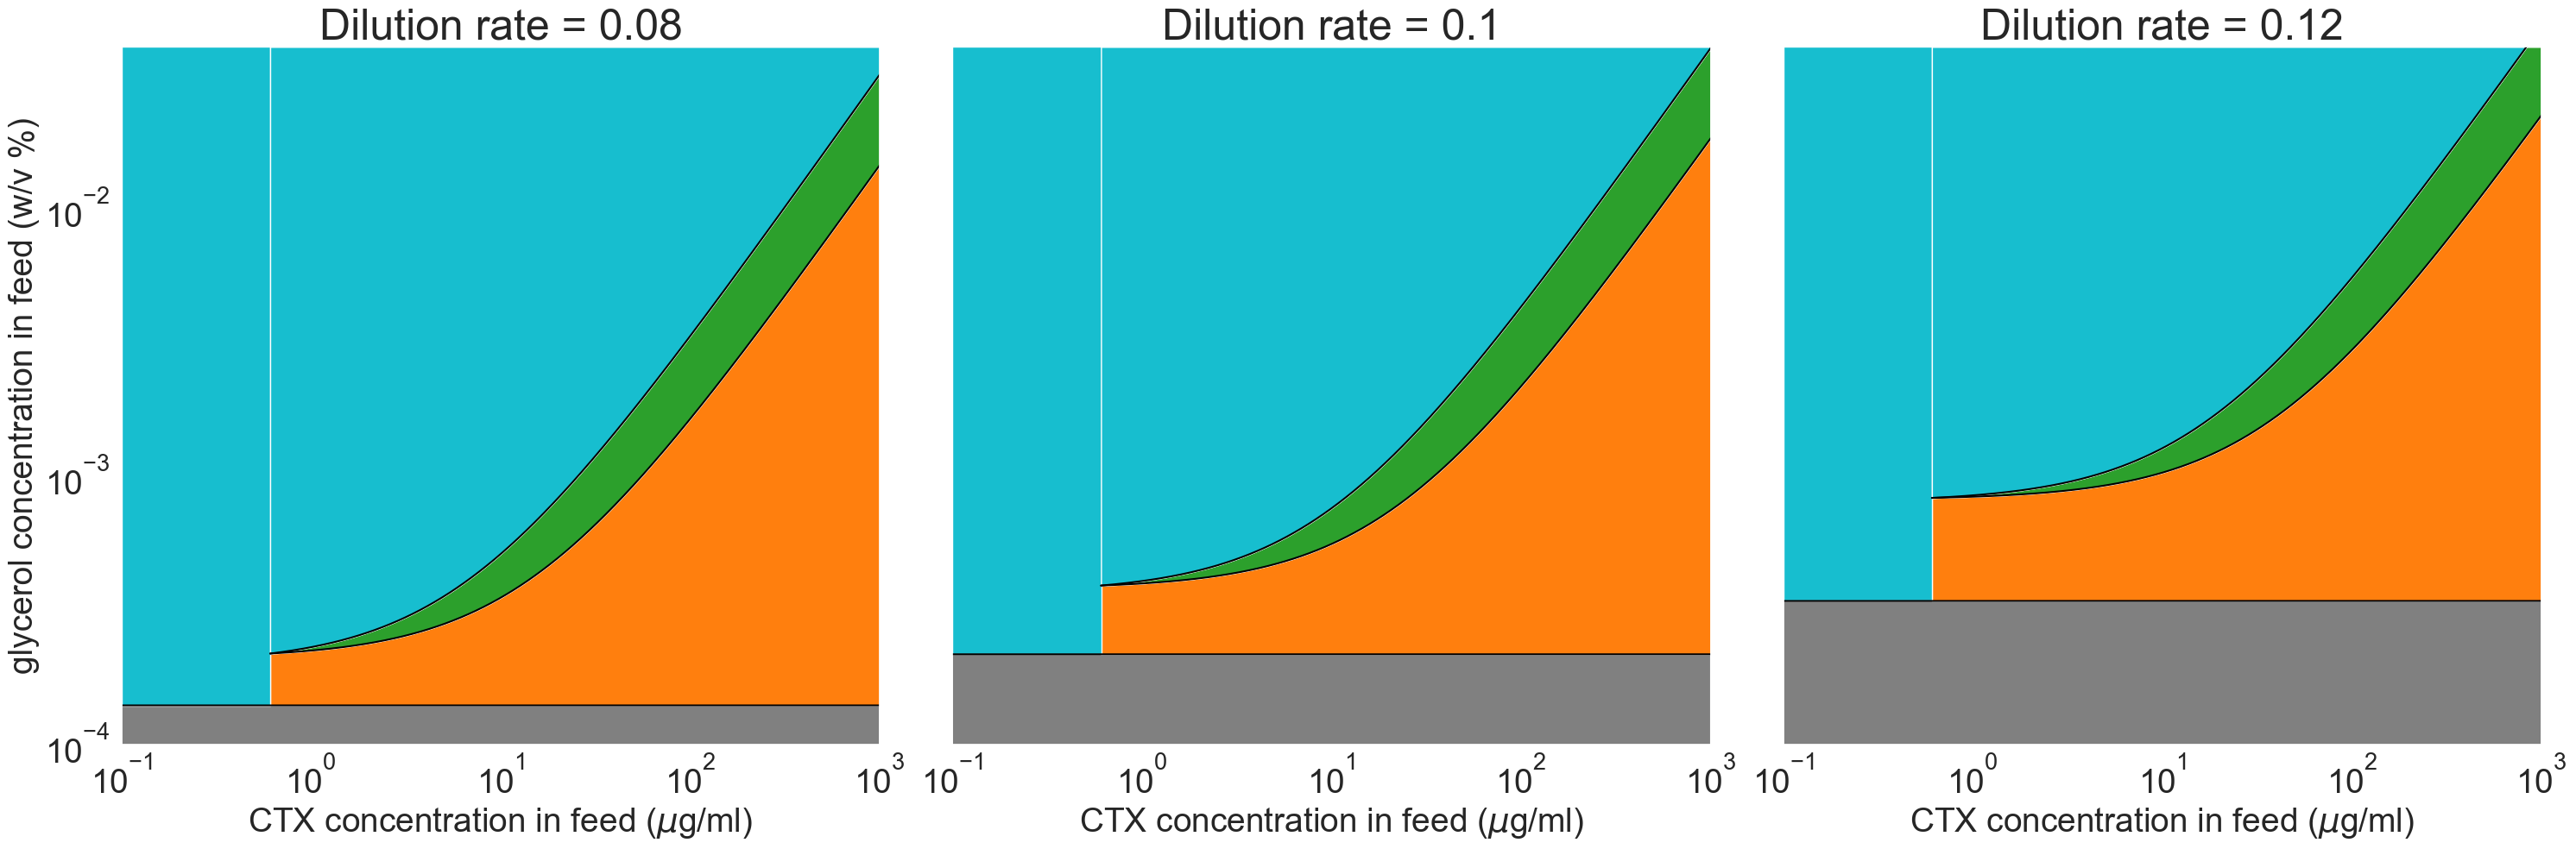

In [8]:
fig, ax = plt.subplots(1,3, figsize=(30,10))

dilution_rates = [0.08, 0.1, 0.12]
feed_a_plot = np.arange(sol_a_eq, 1000, 0.01)
feed_a_plot_long = np.arange(.1, 1000, 0.01)
feed_a_plot_short = np.arange(.1, sol_a_eq+0.01, 0.01)
max_plot_short = np.repeat(0.04, len(feed_a_plot_short))

for i in [0,1,2]:
    d = dilution_rates[i]
    feed_g_R_coex_plot = ffc.feed_g_R_coex(feed_a_plot, d, sol_a_eq, muR=ffc.growth(sol_a_eq, **p_R), **p_R)
    feed_g_coex_S_plot = ffc.feed_g_coex_S(feed_a_plot, d, sol_a_eq, muS=ffc.growth(sol_a_eq, **p_S), **p_S)
    min_g_plot = np.repeat(ffc.g_min(d, mu=ffc.growth(0, **p_S), **p_S), len(feed_a_plot))

    min_g_plot_long = np.repeat(ffc.g_min(d, mu=ffc.growth(0, **p_S), **p_S), len(feed_a_plot_long))

    min_g_plot_short = np.repeat(ffc.g_min(d, mu=ffc.growth(0, **p_S), **p_S), len(feed_a_plot_short))
    ax[i].plot(feed_a_plot, feed_g_R_coex_plot, feed_a_plot, feed_g_coex_S_plot, color='black')
    
    ax[i].plot(feed_a_plot_long, min_g_plot_long, color='black')

    ax[i].fill_between(feed_a_plot_long, 0, min_g_plot_long, facecolor='gray')
    ax[i].fill_between(feed_a_plot, min_g_plot, feed_g_R_coex_plot, facecolor='tab:orange')
    ax[i].fill_between(feed_a_plot_short, min_g_plot_short, max_plot_short, facecolor='tab:cyan')
    ax[i].fill_between(feed_a_plot, feed_g_R_coex_plot, feed_g_coex_S_plot, facecolor='tab:green')
    ax[i].fill_between(feed_a_plot, feed_g_coex_S_plot, 0.04, facecolor='tab:cyan')

    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].xaxis.set_tick_params(labelsize=28)
    ax[i].yaxis.set_tick_params(labelsize=28)
    if i>0:
        ax[i].tick_params('y', labelleft=False)

    ax[i].set_xlabel(r'CTX concentration in feed ($\mu$g/ml)', size=28)
    if i==0:
        ax[i].set_ylabel('glycerol concentration in feed (w/v %)', size=28)
    ax[i].set_title('Dilution rate = '+str(d), size=36)

    ax[i].set_ylim(0.0001,0.04)
    ax[i].set_xlim(.1,1000)

plt.tight_layout()
#plt.savefig("timesim_conf.jpg")

### We now do the same for a fixed dilutrion rate of 0.1 but some changes in the parameters of the species

In [9]:
sol_a_eq_stored = sol_a_eq.copy()
func_equal_growth_high_growth = lambda a: (ffc.growth(a, **p_R_highGrowth) - ffc.growth(a, **p_S_highGrowth))**2
sol_a_eq_high_growth = fsolve(func_equal_growth_high_growth, 0.6)[0]
func_equal_growth_low_growth = lambda a: (ffc.growth(a, **p_R_lowGrowth) - ffc.growth(a, **p_S_lowGrowth))**2
sol_a_eq_low_growth = fsolve(func_equal_growth_low_growth, 0.6)[0]
print('Eq a: ', sol_a_eq, '\nEq a high growth: ', sol_a_eq_high_growth, '\nEq a low growth: ', sol_a_eq_low_growth)

Eq a:  0.6089965534101354 
Eq a high growth:  0.605918162138078 
Eq a low growth:  0.6121452966633072


In [10]:
mu_coex = ffc.growth(sol_a_eq, **p_R)
mu_coex_stored = mu_coex.copy()
mu_coex_high_growth = ffc.growth(sol_a_eq_high_growth, **p_R_highGrowth)
mu_coex_low_growth = ffc.growth(sol_a_eq_low_growth, **p_R_lowGrowth)
print('Eq mu: ', mu_coex, '\nEq mu high growth: ', mu_coex_high_growth, '\nEq mu low growth: ', mu_coex_low_growth)

Eq mu:  0.14599999999997237 
Eq mu high growth:  0.1759999999999735 
Eq mu low growth:  0.11599999999997124


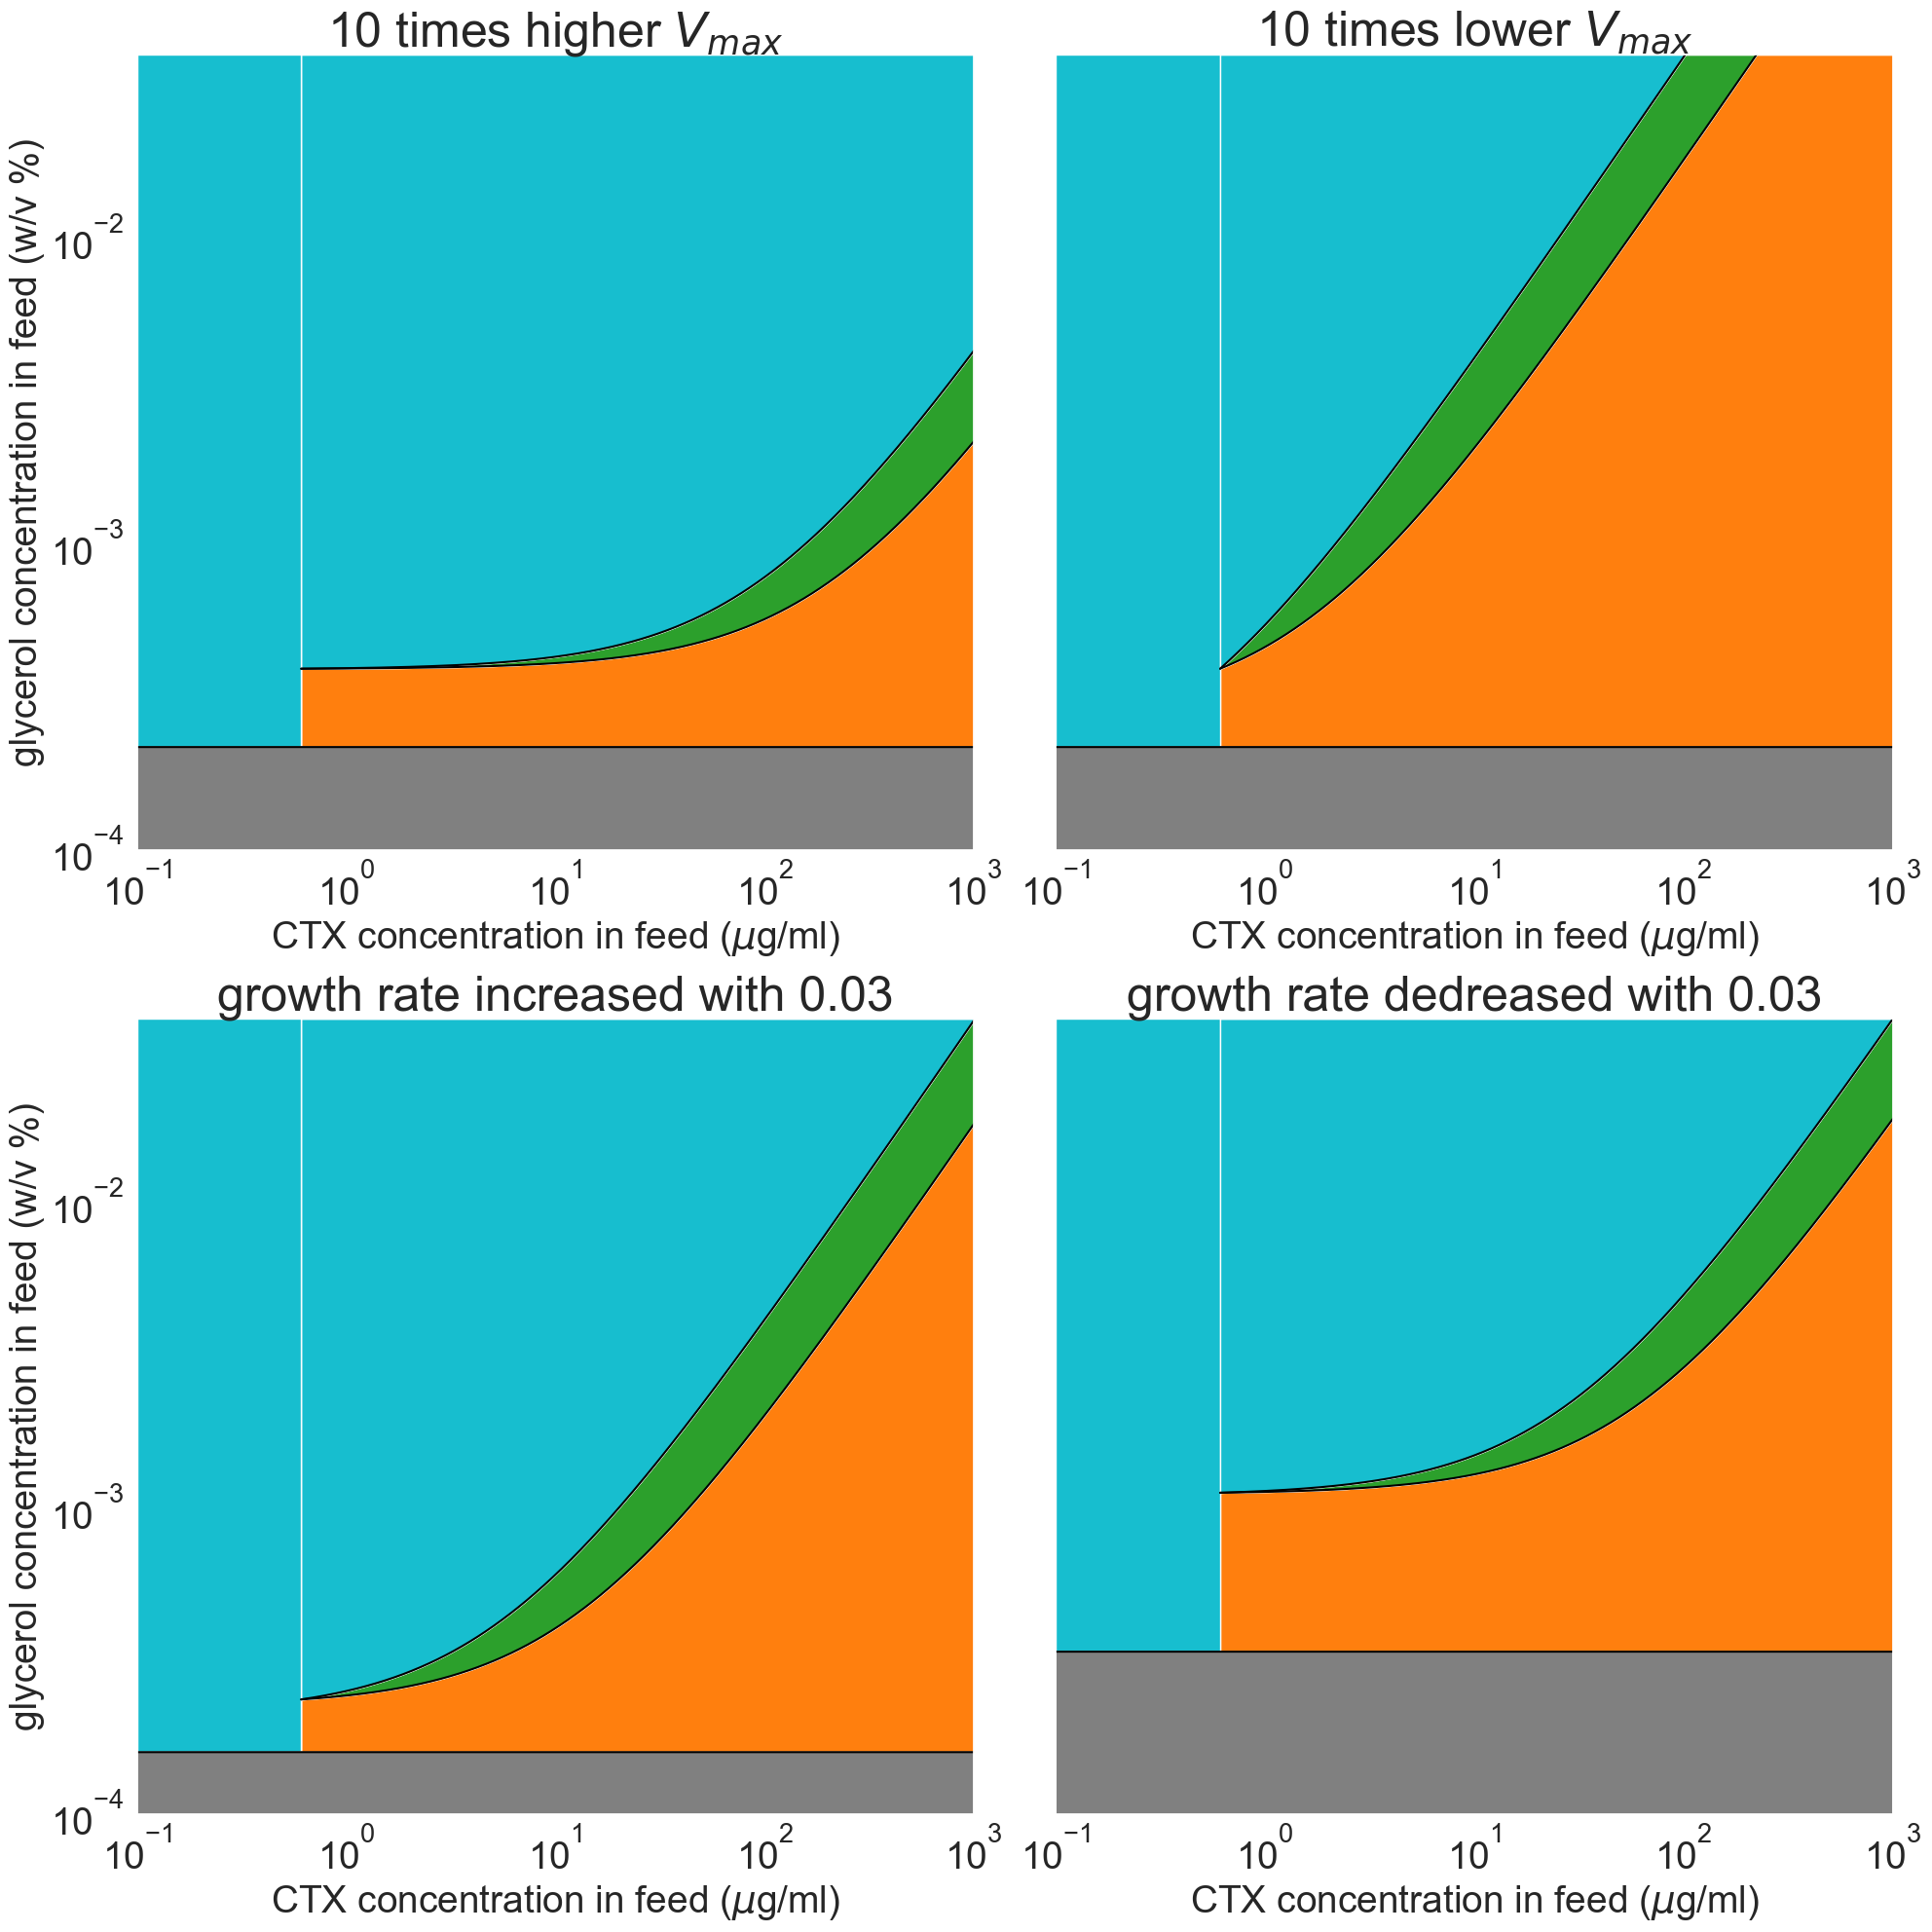

In [11]:
fig, ax = plt.subplots(2,2, figsize=(20,20))

d = 0.1
feed_a_plot = np.arange(sol_a_eq, 1000, 0.01)
feed_a_plot_long = np.arange(.1, 1000, 0.01)
feed_a_plot_short = np.arange(.1, sol_a_eq+0.01, 0.01)
max_plot_short = np.repeat(0.04, len(feed_a_plot_short))


for j in [0,1]:
    for i in [0,1]:
        if j==0 and i==0:
            p_R = p_R_highVmax.copy()
            p_S = p_S_highVmax.copy()
        elif j==0 and i==1:
            p_R = p_R_lowVmax.copy()
            p_S = p_S_lowVmax.copy()
        elif j==1 and i==0:
            p_R = p_R_highGrowth.copy()
            p_S = p_S_highGrowth.copy()
            sol_a_eq = sol_a_eq_high_growth.copy()
            mu_coex = mu_coex_high_growth.copy()
        elif j==1 and i==1:
            p_R = p_R_lowGrowth.copy()
            p_S = p_S_lowGrowth.copy()
            sol_a_eq = sol_a_eq_low_growth.copy()
            mu_coex = mu_coex_low_growth.copy()
        feed_g_R_coex_plot = ffc.feed_g_R_coex(feed_a_plot, d, sol_a_eq, muR=ffc.growth(sol_a_eq, **p_R), **p_R)
        feed_g_coex_S_plot = ffc.feed_g_coex_S(feed_a_plot, d, sol_a_eq, muS=ffc.growth(sol_a_eq, **p_S), **p_S)
        min_g_plot = np.repeat(ffc.g_min(d, mu=ffc.growth(0, **p_S), **p_S), len(feed_a_plot))

        min_g_plot_long = np.repeat(ffc.g_min(d, mu=ffc.growth(0, **p_S), **p_S), len(feed_a_plot_long))

        min_g_plot_short = np.repeat(ffc.g_min(d, mu=ffc.growth(0, **p_S), **p_S), len(feed_a_plot_short))
        ax[j][i].plot(feed_a_plot, feed_g_R_coex_plot, feed_a_plot, feed_g_coex_S_plot, color='black')
    
        ax[j][i].plot(feed_a_plot_long, min_g_plot_long, color='black')

        ax[j][i].fill_between(feed_a_plot, min_g_plot, feed_g_R_coex_plot, facecolor='tab:orange')
        ax[j][i].fill_between(feed_a_plot_short, min_g_plot_short, max_plot_short, facecolor='tab:cyan')
        ax[j][i].fill_between(feed_a_plot, feed_g_R_coex_plot, feed_g_coex_S_plot, facecolor='tab:green')
        ax[j][i].fill_between(feed_a_plot, feed_g_coex_S_plot, 0.04, facecolor='tab:cyan')
        ax[j][i].fill_between(feed_a_plot_long, 0, min_g_plot_long, facecolor='gray')

        ax[j][i].set_yscale('log')
        ax[j][i].set_xscale('log')
        ax[j][i].xaxis.set_tick_params(labelsize=28)
        ax[j][i].yaxis.set_tick_params(labelsize=28)
        if i>0:
            ax[j][i].tick_params('y', labelleft=False)

        ax[j][i].set_xlabel(r'CTX concentration in feed ($\mu$g/ml)', size=28)
        if i==0:
            ax[j][i].set_ylabel('glycerol concentration in feed (w/v %)', size=28)

        ax[j][i].set_ylim(0.0001,0.04)
        ax[j][i].set_xlim(.1,1000)
        p_R = p_R_stored.copy()
        p_S = p_S_stored.copy()
        sol_a_eq = sol_a_eq_stored.copy()
        mu_coex = mu_coex_stored.copy()

ax[0][0].set_title('10 times higher $V_{max}$', size=36)
ax[0][1].set_title('10 times lower $V_{max}$', size=36)
ax[1][0].set_title('growth rate increased with 0.03', size=36)
ax[1][1].set_title('growth rate dedreased with 0.03', size=36)

plt.tight_layout()
#plt.savefig("diff_parameters.jpg")

# Plotting a contourplot with the equilibrium ratio (not used for figures in the article or supplementary information)

We make a version of the function that can be used to calculate a mesh grid

In [12]:
equilibrium_ratio_d01 = partial(ffc.equilibrium_ratio, d=0.1, sol_a_eq=sol_a_eq, p_S=p_S, p_R=p_R)
equilibrium_ratio_array = np.frompyfunc(equilibrium_ratio_d01, 2, 1)

We define the ranges for the feed concentrations of a (CTX, ug/ml) and s (glycerol, %)

In [13]:
a_list = np.geomspace(.1,1000,400)
s_list = np.geomspace(0.0001,0.04,400)

A, S = np.meshgrid(a_list, s_list)
EQ = equilibrium_ratio_array(A,S)
EQ = EQ.astype(float)
EQ_ma = ma.masked_values(EQ, -1)

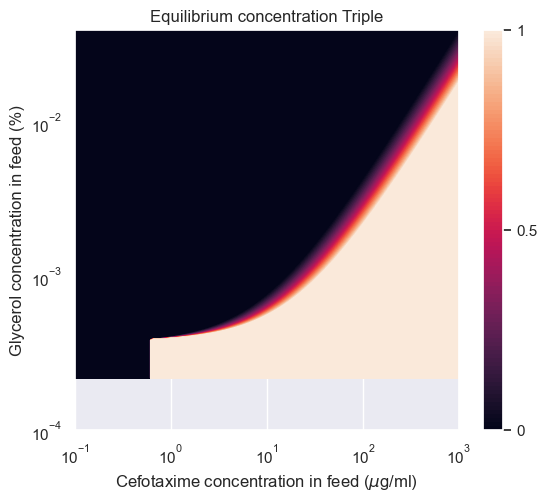

In [14]:
fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

levels = np.linspace(0,1,101, endpoint=True)
cp = plt.contourf(A, S, EQ_ma, levels)
cbar = plt.colorbar(cp)
cbar.set_ticks([0,.5,1])
cbar.set_ticklabels([0,.5,1])

ax.set_title('Equilibrium concentration Triple')
ax.set_xlabel(r'Cefotaxime concentration in feed ($\mu$g/ml)')
ax.set_ylabel('Glycerol concentration in feed (%)')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(.1, 1000)
ax.set_ylim(0.0001, 0.04)
plt.show()